In [1]:
from transformers import AutoModel, AutoTokenizer
import datasets
import torch
import os
import csv
import gzip
from sentence_transformers import InputExample
from tqdm import tqdm
import matplotlib.pyplot as plt

sts_dataset_path = '../datasets/stsbenchmark.tsv.gz'

if not os.path.exists(sts_dataset_path):
    util.http_get('https://sbert.net/datasets/stsbenchmark.tsv.gz', sts_dataset_path)

train_samples = []
dev_samples = []
test_samples = []
with gzip.open(sts_dataset_path, 'rt', encoding='utf8') as fIn:
    reader = csv.DictReader(fIn, delimiter='\t', quoting=csv.QUOTE_NONE)
    for row in reader:
        score = float(row['score']) / 5.0  # Normalize score to range 0 ... 1
        inp_example = InputExample(texts=[row['sentence1'], row['sentence2']], label=score)

        if row['split'] == 'dev':
            dev_samples.append(inp_example)
        elif row['split'] == 'test':
            test_samples.append(inp_example)
        else:
            train_samples.append(inp_example)


In [2]:
def batch_to_device(batch, device):
    return {k:v.to(device) for k, v in batch.items()}

def model_forward(data, model, tokenizer, device, depth):
    s1, s2 = [], []
    for d in data:
        s1.append(d.texts[0])
        s2.append(d.texts[1])

    s1_tok = batch_to_device(tokenizer(s1, return_tensors="pt", truncation=True, padding=True), device)
    s2_tok = batch_to_device(tokenizer(s2, return_tensors="pt", truncation=True, padding=True), device)
    
    s1_out = model(**s1_tok, output_hidden_states=True).hidden_states
    s2_out = model(**s2_tok, output_hidden_states=True).hidden_states

    return s1_out[depth], s2_out[depth], s1_tok["attention_mask"], s2_tok["attention_mask"]
    
def calculate_embeddings(samples, batch_size, model, tokenizer, device, depth):
    embeddings = []
    
    for i in tqdm(range(len(samples) // batch_size + int(len(samples) % batch_size != 0))):
        data = samples[i*batch_size:(i+1)*batch_size]
        out1, out2, att1, att2 = model_forward(data, model, tokenizer, device, depth)
    
        for j, x in enumerate(out1):
            x_tmp = x[att1[j].bool()]
            embeddings.append(x_tmp)
            norms.append(torch.linalg.norm(x_tmp).detach().cpu())
            ranks.append(torch.linalg.matrix_rank(x_tmp).detach().cpu())
            conds.append(torch.linalg.cond(x_tmp).detach().cpu())
                
        for j, x in enumerate(out2):
            x_tmp = x[att2[j].bool()]
            norms.append(torch.linalg.norm(x_tmp).detach().cpu())
            ranks.append(torch.linalg.matrix_rank(x_tmp).detach().cpu())
            conds.append(torch.linalg.cond(x_tmp).detach().cpu())
        
    return norms, ranks, conds

100%|███████████████████████████████████████████| 44/44 [00:06<00:00,  7.25it/s]


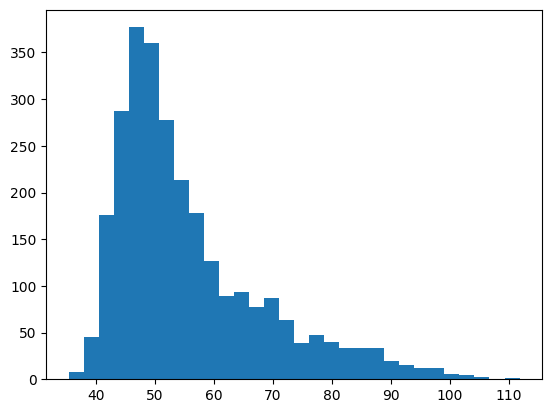

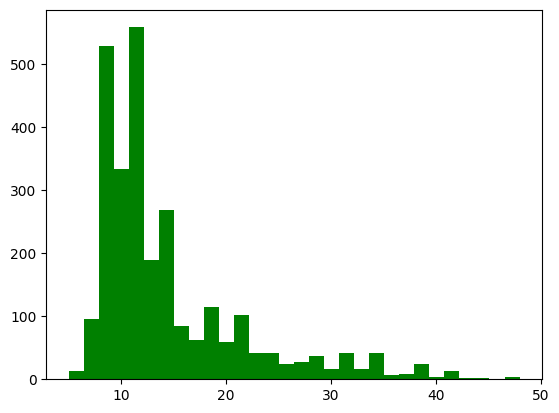

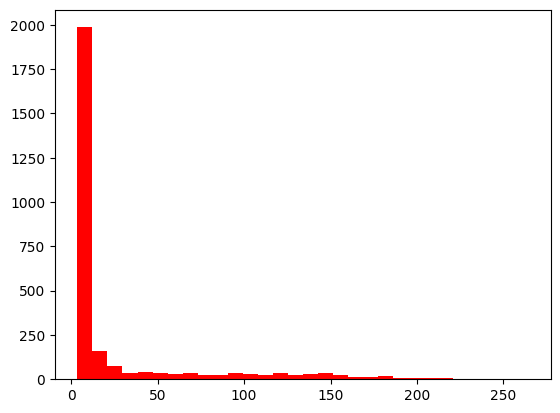

In [6]:
model_name = "bert-base-cased"
batch_size = 32
device = "cuda:0"
depth = 12

model = AutoModel.from_pretrained(model_name).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)
norms, ranks, conds = calculate_embedding_stats(test_samples, batch_size, model, tokenizer, device, depth)

plt.hist(norms, bins=30)
plt.show()
plt.hist(ranks, bins=30, color="g")
plt.show()
plt.hist(conds, bins=30, color="r")
plt.show()

100%|███████████████████████████████████████████| 44/44 [00:05<00:00,  7.38it/s]


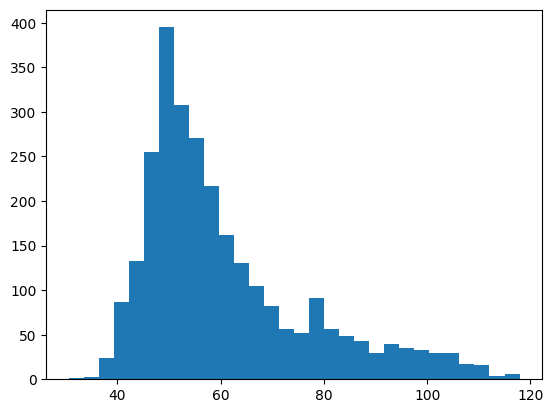

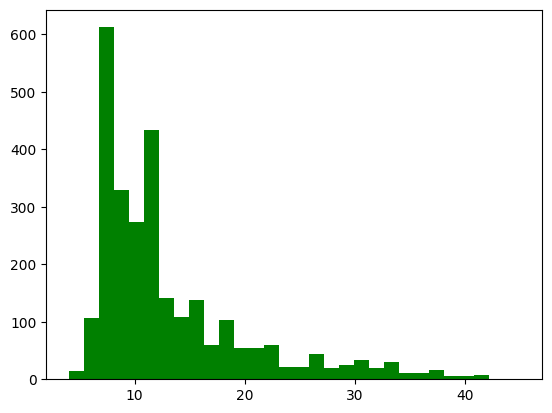

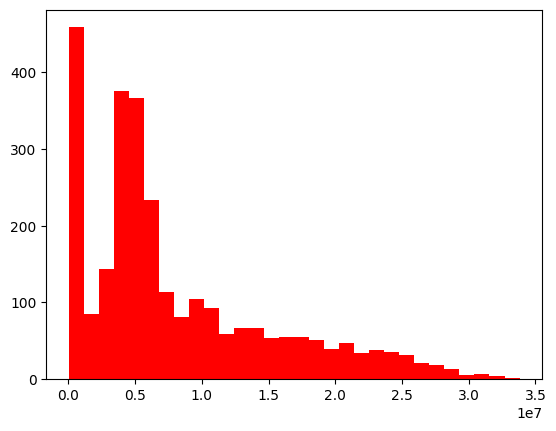

In [6]:
model_name = "google/electra-base-discriminator"
batch_size = 32
device = "cuda:1"
depth = 12

model = AutoModel.from_pretrained(model_name).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)
norms, ranks, conds = calculate_embedding_stats(test_samples, batch_size, model, tokenizer, device, depth)

plt.hist(norms, bins=30)
plt.show()
plt.hist(ranks, bins=30, color="g")
plt.show()
plt.hist(conds, bins=30, color="r")
plt.show()

100%|███████████████████████████████████████████| 44/44 [00:04<00:00, 10.72it/s]


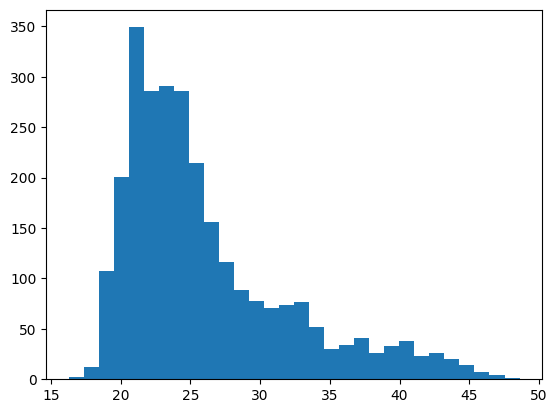

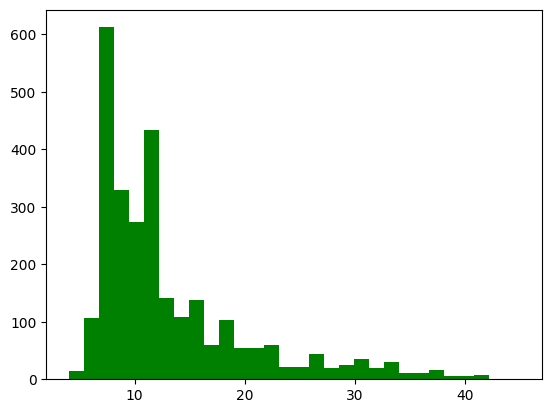

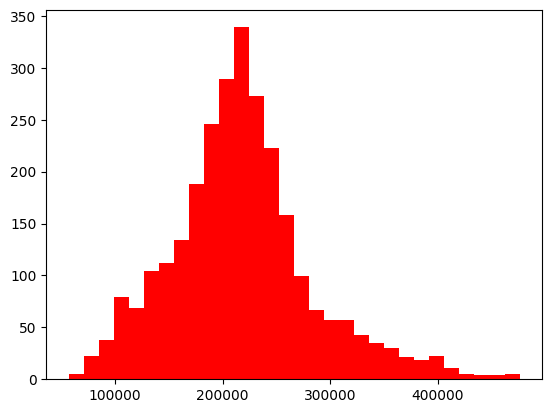

In [5]:
model_name = "google/electra-base-generator"
batch_size = 32
device = "cuda:1"
depth = 12

model = AutoModel.from_pretrained(model_name).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)
norms, ranks, conds = calculate_embedding_stats(test_samples, batch_size, model, tokenizer, device, depth)

plt.hist(norms, bins=30)
plt.show()
plt.hist(ranks, bins=30, color="g")
plt.show()
plt.hist(conds, bins=30, color="r")
plt.show()